# Margin Adapt

In [10]:
%load_ext autoreload
%autoreload 2
%pylab
%matplotlib inline

import os
import sys
import pandas as pd
import pickle
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [11]:
from batch_sv_system_utils import get_embeds, cosine_sim, compute_error, compute_eer

In [555]:
from utils import key2df, df2dict

# embed_dir = "embeddings/voxc2_fbank64_voxc2untied_tdnn7_embeds/"
embed_dir = "embeddings/voxc1adapt_fbank64_embeds/"
keys = pickle.load(open(embed_dir + "/sv_keys.pkl", "rb"))
sv_embeds = np.load(embed_dir + "/sv_embeds.npy")
key_df = key2df(keys)
id2idx, idx2id = df2dict(key_df) 

In [553]:
# plda_model_dir = embed_dir + "plda_train/"
plda_model_dir = None

In [558]:
trial = pickle.load(open("trials/enr306/short_enr1/trials.pkl", "rb"))

## Run Trial - Score fusion

In [562]:
t_idx = 4

### for short
enr_spk, enr_ids, adapt_trial, test_trial= trial[t_idx]

### for closed_set
# enr_spk, enr_ids, test_trial, adapt_trial, ood_trial= trial[t_idx]
# test_trial = list(test_trial)
# test_trial[0] = test_trial[0] + ood_trial[0]
# test_trial[1] = test_trial[1] + ood_trial[1]

In [567]:
vT = 0.5
eT = 0.6
neT = 0.4 

[eer] eer=0.0500, fpr=0.0500, fnr=0.0500, thres=0.5700
[clf] error=0.1545, fpr=0.1650, fnr=0.0500, thres=0.5000


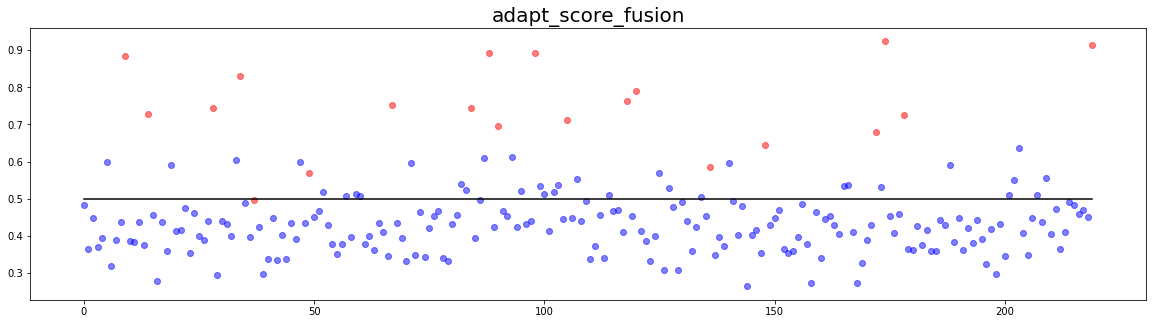

[pos_adapt] n_adapted:21, adapt_acc:0.810
[neg_adapt] n_adapted:23, adapt_acc:0.957
[eer] eer=0.0440, fpr=0.0440, fnr=0.0418, thres=0.5685
[clf] error=0.1228, fpr=0.1623, fnr=0.0020, thres=0.5000
[clf_neg_mask] error=0.0608, fpr=0.0090, fnr=0.2192, thres=0.5000


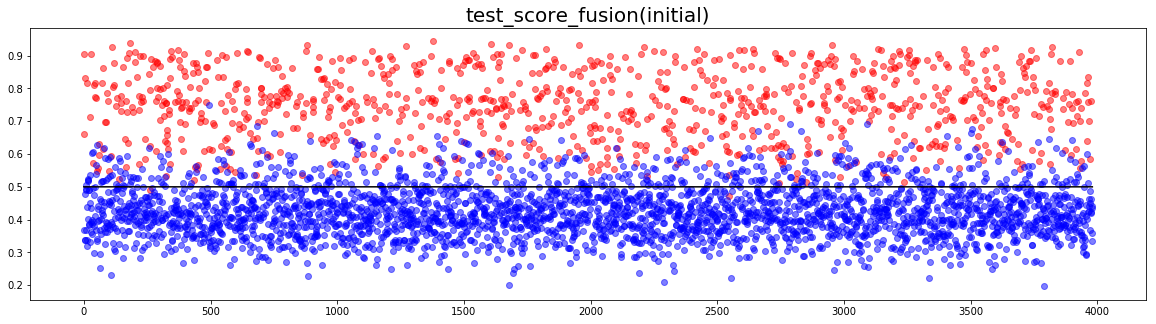

[eer] eer=0.0210, fpr=0.0210, fnr=0.0204, thres=0.6035
[clf] error=0.1550, fpr=0.2057, fnr=0.0000, thres=0.5000
[clf_neg_mask] error=0.0304, fpr=0.0033, fnr=0.1131, thres=0.5000


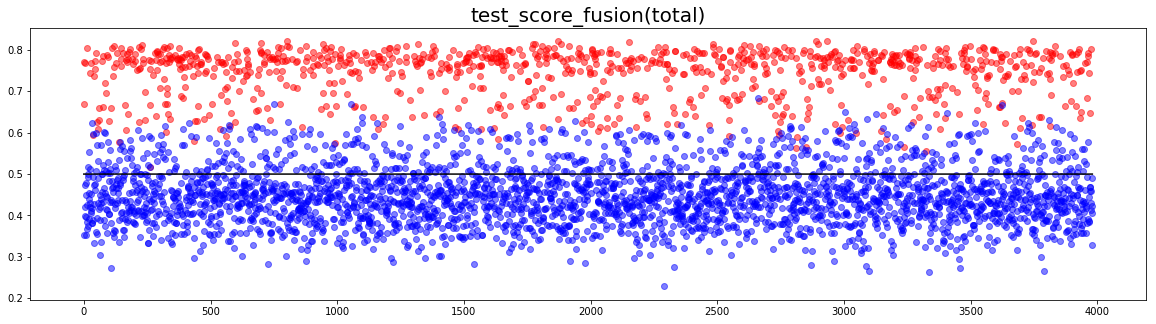

In [568]:
from batch_sv_system_utils import run_trial, plot_score 

### get embeds
enr_embeds = get_embeds(enr_ids, sv_embeds, id2idx, norm=(not plda_model_dir))
adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, id2idx, norm=(not plda_model_dir))
test_embeds = get_embeds(test_trial[0], sv_embeds, id2idx, norm=(not plda_model_dir))

### adapt trial
adapt_scores = run_trial(enr_embeds, adapt_embeds, adapt_trial[1], threshold=vT,
                         plda_dir=plda_model_dir, 
                         title="adapt_score_fusion")
adapt_enr_idx = np.nonzero(adapt_scores.mean(0) > eT)
adapt_enr_embeds = adapt_embeds[adapt_enr_idx]
adapt_enr_acc = np.array(adapt_trial[1])[adapt_enr_idx].mean()
print("[pos_adapt] n_adapted:{}, adapt_acc:{:.3f}".format(len(adapt_enr_idx[0]), adapt_enr_acc))

# neg_enr_idx = np.nonzero(adapt_scores.mean(0) < neT)
# neg_enr_embeds = adapt_embeds[neg_enr_idx]

# oracle neg_embeds
neg_enr_embeds = adapt_embeds[np.array(adapt_trial[1]) == 0]

neg_enr_acc = (1 - np.array(adapt_trial[1]))[neg_enr_idx].mean()
print("[neg_adapt] n_adapted:{}, adapt_acc:{:.3f}".format(len(neg_enr_idx[0]), neg_enr_acc))

### score fusion
total_enr_embeds = np.concatenate([enr_embeds, adapt_enr_embeds], axis=0)

### test trial
init_test_scores = run_trial(enr_embeds[:1], test_embeds, test_trial[1], threshold=vT, 
                                  plda_dir=plda_model_dir, neg_embeds=neg_enr_embeds,
                                  plot=True, title="test_score_fusion(initial)")

total_test_scores = run_trial(total_enr_embeds, test_embeds, test_trial[1], threshold=vT, 
                              plda_dir=plda_model_dir, neg_embeds=neg_enr_embeds,
                              plot=True, title="test_score_fusion(total)")

## Searching the best enrollmnet

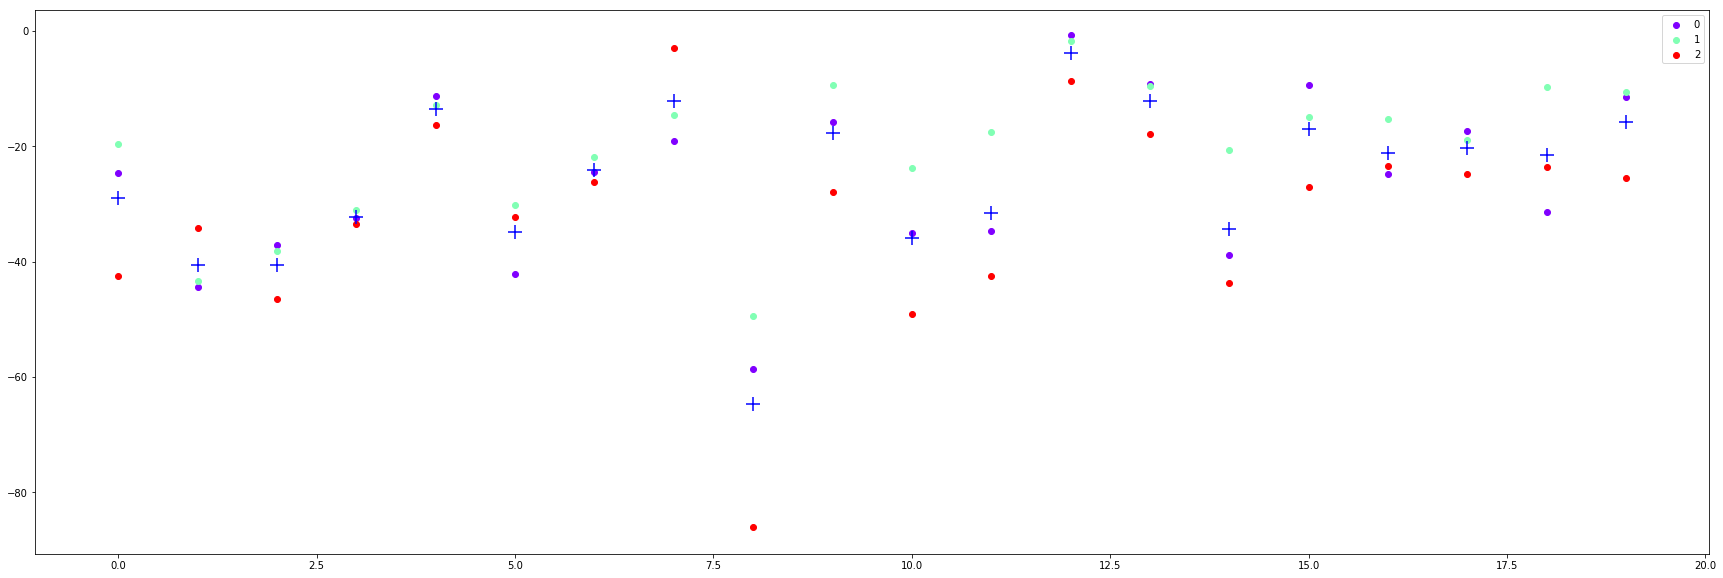

In [109]:
test_labels = np.array(test_trial[1])
scores_subset = total_test_scores[0:5, -20:]
labels_subset = test_labels[-20:]
plt.figure(figsize=(30, 10))
x = np.arange(scores_subset.shape[1])
ys = scores_subset
colors = cm.rainbow(np.linspace(0, 1, len(ys)))
s_set = []
for y, c in zip(ys, colors):
    s = plt.scatter(x, y, color=c)
    s_set.append(s)
plt.legend(s_set, range(len(s_set)))
y_mean = scores_subset.mean(0)
plt.scatter(x[labels_subset==1], y_mean[labels_subset==1], marker='+', s=200, color='r')
plt.scatter(x[labels_subset==0], y_mean[labels_subset==0], marker='+', s=200, color='b')

## Iterate trials

In [557]:
init_pos_scores = []
init_neg_scores = []
init_eers = []
total_pos_scores = []
total_neg_scores = []
total_eers = []

for i, tr in enumerate(trial):
    enr_spk, enr_ids, test_trial, adapt_trial, ood_trial= tr
    test_trial = list(test_trial)
    test_trial[0] = test_trial[0] + ood_trial[0]
    test_trial[1] = test_trial[1] + ood_trial[1]
    test_trial[1] = np.array(test_trial[1])
    
    ### get embeds
    enr_embeds = get_embeds(enr_ids, sv_embeds, id2idx, norm=(not plda_model_dir))
    adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, id2idx, norm=(not plda_model_dir))
    test_embeds = get_embeds(test_trial[0], sv_embeds, id2idx, norm=(not plda_model_dir))

    ### adapt trial
    adapt_scores = run_trial(enr_embeds, adapt_embeds, adapt_trial[1], threshold=vT,
                             plda_dir=plda_model_dir,
                             plot=False, verbose=False) 
    adapt_enr_idx = np.nonzero(adapt_scores.mean(0) > eT)
    adapt_enr_embeds = adapt_embeds[adapt_enr_idx]
    adapt_enr_acc = np.array(adapt_trial[1])[adapt_enr_idx].mean()
#     print("[pos_adapt] n_adapted:{}, adapt_acc:{:.3f}".format(len(adapt_enr_idx[0]), adapt_enr_acc))

    neg_enr_idx = np.nonzero(adapt_scores.mean(0) < neT)
    neg_enr_embeds = adapt_embeds[neg_enr_idx]
    neg_enr_acc = (1 - np.array(adapt_trial[1]))[neg_enr_idx].mean()
#     print("[neg_adapt] n_adapted:{}, adapt_acc:{:.3f}".format(len(neg_enr_idx[0]), neg_enr_acc))

    ### score fusion
    total_enr_embeds = np.concatenate([enr_embeds, adapt_enr_embeds], axis=0)

    ### test trial
    init_test_scores = run_trial(enr_embeds[:1], test_embeds, test_trial[1], threshold=vT, 
                                 plda_dir=plda_model_dir, neg_embeds=neg_enr_embeds, 
                                 plot=False, verbose=True)

    total_test_scores = run_trial(total_enr_embeds, test_embeds, test_trial[1], threshold=vT, 
                                  plda_dir=plda_model_dir, neg_embeds=neg_enr_embeds, 
                                  plot=False, verbose=True)
    print()
    


[eer] eer=0.0299, fpr=0.0299, fnr=0.0281, thres=0.5347
[clf] error=0.0493, fpr=0.0746, fnr=0.0112, thres=0.5000
[clf_neg_mask] error=0.0381, fpr=0.0149, fnr=0.0730, thres=0.5000
[eer] eer=0.0112, fpr=0.0112, fnr=0.0112, thres=0.5691
[clf] error=0.0336, fpr=0.0560, fnr=0.0000, thres=0.5000
[clf_neg_mask] error=0.0247, fpr=0.0187, fnr=0.0337, thres=0.5000

[eer] eer=0.0476, fpr=0.0407, fnr=0.0476, thres=0.5908
[clf] error=0.1712, fpr=0.2805, fnr=0.0068, thres=0.5000
[clf_neg_mask] error=0.0571, fpr=0.0407, fnr=0.0816, thres=0.5000
[eer] eer=0.0340, fpr=0.0317, fnr=0.0340, thres=0.6285
[clf] error=0.1658, fpr=0.2760, fnr=0.0000, thres=0.5000
[clf_neg_mask] error=0.0598, fpr=0.0769, fnr=0.0340, thres=0.5000

[eer] eer=0.1538, fpr=0.1496, fnr=0.1538, thres=0.5244
[clf] error=0.1711, fpr=0.2445, fnr=0.0604, thres=0.5000
[clf_neg_mask] error=0.1623, fpr=0.0328, fnr=0.3571, thres=0.5000
[eer] eer=0.0401, fpr=0.0401, fnr=0.0385, thres=0.5514
[clf] error=0.0592, fpr=0.0949, fnr=0.0055, thres=0.5

/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice.
/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/host/projects/sv_experiments/exp_adaptive_sv/batch_sv_system_utils.py:120: RuntimeWarning: Mean of empty slice.
  neg_score_fusion = neg_score.mean(0)
/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/host/projects/sv_experiments/exp_adaptive_sv/batch_sv_system_utils.py:125: RuntimeWarning: invalid value encountered in greater
  neg_mask = (score_fusion - neg_score_fusion) > 0.20


[eer] eer=0.0338, fpr=0.0338, fnr=0.0331, thres=0.6375
[clf] error=0.2372, fpr=0.3950, fnr=0.0000, thres=0.5000
[clf_neg_mask] error=0.0935, fpr=0.1468, fnr=0.0132, thres=0.5000

[eer] eer=0.0432, fpr=0.0431, fnr=0.0432, thres=0.6053
[clf] error=0.2184, fpr=0.3589, fnr=0.0072, thres=0.5000
[clf_neg_mask] error=0.0460, fpr=0.0526, fnr=0.0360, thres=0.5000
[eer] eer=0.0287, fpr=0.0287, fnr=0.0216, thres=0.6362
[clf] error=0.2644, fpr=0.4402, fnr=0.0000, thres=0.5000
[clf_neg_mask] error=0.0747, fpr=0.1148, fnr=0.0144, thres=0.5000

[eer] eer=0.0930, fpr=0.0923, fnr=0.0930, thres=0.5064
[clf] error=0.0895, fpr=0.1026, fnr=0.0698, thres=0.5000
[clf_neg_mask] error=0.1019, fpr=0.0000, fnr=0.2558, thres=0.5000
[eer] eer=0.0233, fpr=0.0154, fnr=0.0233, thres=0.5306
[clf] error=0.0401, fpr=0.0513, fnr=0.0233, thres=0.5000
[clf_neg_mask] error=0.0494, fpr=0.0000, fnr=0.1240, thres=0.5000

[eer] eer=0.2759, fpr=0.2748, fnr=0.2759, thres=0.5141
[clf] error=0.2867, fpr=0.3321, fnr=0.2184, thres=0.

/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice.


[eer] eer=0.0000, fpr=0.0000, fnr=0.0000, thres=0.5364
[clf] error=0.0058, fpr=0.0097, fnr=0.0000, thres=0.5000
[clf_neg_mask] error=0.0175, fpr=0.0000, fnr=0.0441, thres=0.5000

[eer] eer=0.0405, fpr=0.0405, fnr=0.0338, thres=0.5685
[clf] error=0.1054, fpr=0.1577, fnr=0.0270, thres=0.5000
[clf_neg_mask] error=0.0351, fpr=0.0270, fnr=0.0473, thres=0.5000
[eer] eer=0.0338, fpr=0.0315, fnr=0.0338, thres=0.5663
[clf] error=0.0757, fpr=0.1216, fnr=0.0068, thres=0.5000
[clf_neg_mask] error=0.0216, fpr=0.0090, fnr=0.0405, thres=0.5000

[eer] eer=0.0234, fpr=0.0233, fnr=0.0234, thres=0.5891
[clf] error=0.1192, fpr=0.1984, fnr=0.0000, thres=0.5000
[clf_neg_mask] error=0.0117, fpr=0.0078, fnr=0.0175, thres=0.5000
[eer] eer=0.0000, fpr=0.0000, fnr=0.0000, thres=0.6153
[clf] error=0.0444, fpr=0.0739, fnr=0.0000, thres=0.5000
[clf_neg_mask] error=0.0000, fpr=0.0000, fnr=0.0000, thres=0.5000

[eer] eer=0.0161, fpr=0.0160, fnr=0.0161, thres=0.5486
[clf] error=0.0577, fpr=0.0957, fnr=0.0000, thres=0.

In [545]:
# init_pos_scores = np.concatenate(init_pos_scores, axis=1).squeeze()
# init_neg_scores = np.concatenate(init_neg_scores, axis=1).squeeze()
compute_eer(init_pos_scores, init_neg_scores)

ValueError: could not broadcast input array from shape (178) into shape (1)

In [87]:
# total_pos_scores = np.concatenate(total_pos_scores, axis=1).squeeze()
# total_neg_scores = np.concatenate(total_neg_scores, axis=1).squeeze()
compute_eer(total_pos_scores, total_neg_scores)

(0.011813912533020252,
 0.011813912533020252,
 0.01171011931064958,
 -0.9160226999999999)

In [ ]:
init_eer = compute_eer(test_score_fusion[test_trial[1]==1], test_score_fusion[test_trial[1]==0])

In [49]:
test_score_fusion.shape

(446,)

In [51]:
test_trial[1] == 1

False

In [59]:
init_test_scores.shape

(1, 446)